In [ ]:
#!pip install fastai -q --upgrade

In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback
import argparse
from timeit import default_timer as timer

In [2]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch
from torchvision.transforms.functional import *

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

import ipywidgets as widgets
from IPython.display import display, clear_output
import math

In [3]:
#parser = argparse.ArgumentParser()
#parser.add_argument("--local_rank", type=int)
#args = parser.parse_args()

In [4]:
#torch.cuda.set_device(args.local_rank)

In [5]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)
else:
    print("No CUDA")

CUDA Available


In [6]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.utils.joiner3 import *
from models.utils.new_losses import *
from models.utils.metrics import Accuracy
from models.unet import UNet
from models.utils.misc import *
from models.utils.datasets import *

In [7]:
beta = -1e-6
gamma = 3e-3
sigma = 1.2


def Accuracy(preds,target): 
    if len(preds) == 2:
        fakePreds = learner.gan_trainer.critic(preds)
        _, pred = torch.max(fakePreds[0], 1)
        return (pred == target).float().mean()
    else:
        _, pred = torch.max(preds[0], 1)
        return (pred == target).float().mean()
    
def Reconstruction_Loss(preds,target,sigma=1):
    if len(preds) == 2:
        MSE = nn.MSELoss()
        Lrec = sigma*MSE(preds[0],preds[1])
    else:
        Lrec = 0.000
  
    return Lrec

def get_gm(r):
    label = parent_label(r)
    a = attrgetter("name")
    rgex = RegexLabeller(pat = r'image(.*?).jpeg') 
    gm = torch.load(save_path+"/gramm/"+str(label)+"/gm"+rgex(a(r))+".pt")
    return gm, TensorCategory(int(label))

In [32]:
H = 256
W= 256

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor()#,
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform2 = T.Compose([
T.Resize((H,W))#,
#T.ToTensor()
])

transform3 = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [9]:
# def dloader():
#     path = Path.home()/'Luiz/gan_attention/data/ImageNet'
#     save_path = 'data/ImageNet'

#     #transform = ([Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#     dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
#                      get_items=get_image_files, 
#                      splitter=RandomSplitter(),
#                      get_y=parent_label,
#                      item_tfms=Resize(H,W))#,
#                      #batch_tfms=transform)
#     dsets = dblock.datasets(path)

#     dloader = dblock.dataloaders(path, bs=100)
#     return dloader
# dld = dloader()

In [10]:
# for i in range(len(a)):
#     plt.figure(figsize=(14,14))
#     plt.axis('off')
#     plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
#     plt.imshow(transform2(dld.train_ds[a[i]][0]))#.permute(1, 2, 0))
#     plt.savefig('sample_images/image'+str(i)+'.jpeg',dpi=100, bbox_inches='tight', pad_inches=0.0)

In [11]:
# idx = np.random.randint(1000000,size=6)
# print(idx)

In [12]:
# fig, axs = plt.subplots(2, 3, figsize=(12,8))
# axs[0, 0].imshow(transform(dld.train_ds[idx[0]][0]).permute(1, 2, 0))
# axs[0, 1].imshow(transform(dld.train_ds[idx[1]][0]).permute(1, 2, 0))
# axs[0, 2].imshow(transform(dld.train_ds[idx[2]][0]).permute(1, 2, 0))
# axs[1, 0].imshow(transform(dld.train_ds[idx[3]][0]).permute(1, 2, 0))
# axs[1, 1].imshow(transform(dld.train_ds[idx[4]][0]).permute(1, 2, 0))
# axs[1, 2].imshow(transform(dld.train_ds[idx[5]][0]).permute(1, 2, 0))
# #plt.subplot_tool()
# plt.show()

In [590]:
model_dir = Path.home()/'Luiz/saved_models'
net = load_learner(model_dir/'GramImageNet_Rotation_16x16grid_epochs-90-beta-5e-6_PenaltyFactor3_Layer3.pkl', cpu=False)
net2 = load_learner(model_dir/'GramImageNet_Rotation_16x16grid_epochs-90-beta-5e-6_PenaltyFactor2_Layer2.pkl', cpu=False)

In [591]:
weights_dir = Path.home()/'Luiz/gan_attention/models/pretrained'
best_weight = load_learner(weights_dir/'Best_Model_Layer3_ImageNet_Rotation_16x16grid.pth', cpu=False)
best_weight2 = load_learner(weights_dir/'Best_Model_Layer2_ImageNet_Rotation_16x16grid_Loss2.pth', cpu=False)

In [592]:
model = net.model
#model.load_state_dict(best_weight)
model = model.eval()
model = model.to(device)

model2 = net2.model.eval()
#model2.load_state_dict(best_weight2)
model2 = model2.to(device)

In [ ]:
#for n, p in model.named_parameters():
#    print(n, p)

In [ ]:
#for n, p in model2.named_parameters():
#    print(n,p)

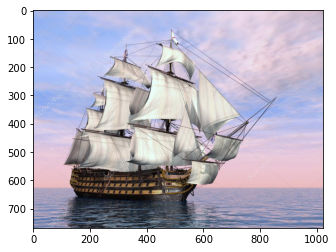

In [59]:
# url1 = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url1 = 'https://cms.qz.com/wp-content/uploads/2019/12/airplane-e1575485422322.jpg?quality=75&strip=all&w=1200&h=900&crop=1'
#url3 = 'https://autocar.com.ph/wp-content/uploads/2018/01/Ayrton_Senna_-_Mclaren_MP4-8_during_practice_for_the_1993_British_Grand_Prix_32873580103.jpg'
# url4 = 'https://static.scientificamerican.com/sciam/cache/file/ACF0A7DC-14E3-4263-93F438F6DA8CE98A_source.jpg?w=590&h=800&896FA922-DF63-4289-86E2E0A5A8D76BE1'
url0 = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
#url3 = 'https://cdn.britannica.com/90/206390-050-69486F6E/eastern-coral-snake.jpg'
url3 = 'https://media.allure.com/photos/596552d8c7982f5ec80b68e8/16:9/w_2560%2Cc_limit/GettyImages-124828421.jpg'
url4 = 'https://st2.depositphotos.com/1020917/7268/i/950/depositphotos_72688965-stock-photo-hms-victory.jpg'

url5 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
url6 = 'https://southernboating.com/wp-content/uploads/2019/11/New-running-530-0832-1024x600.jpg'
IMG_URL = url4
im = Image.open(requests.get(IMG_URL, stream=True).raw)
plt.plot()
plt.imshow(im)

In [ ]:
4,6,10,13,14,16,17

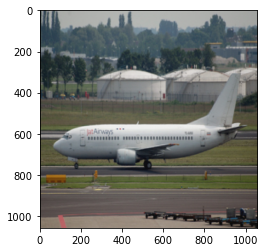

In [45]:
im_idx = 17
im = Image.open('sample_images/image'+str(im_idx)+'.jpeg')#.convert("RGB")
plt.plot()
plt.imshow(im)

In [46]:
img = transform(im).unsqueeze(0).to(device)
print("Input shape:", img.shape)
#print(model.noise_mode)

Input shape: torch.Size([1, 3, 256, 256])


In [47]:
#model.noise_mode = True
outputs, attn, sattn, gm  = model(img.to(device))#, x1, x0 
#outputs2, sattn2, cat2 = model2(img.to(device))
#print(cat)

In [48]:
sattn[0].shape

torch.Size([1, 256, 256])

In [627]:
model2.noise_mode = True
outputs2, attn, sattn2, gm2 = model2(img.to(device))
#outputs2, sattn2 = model2(x1)
#print(cat2)

In [628]:
a = 16
sattn11 = sattn[0].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn12 = sattn[1].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn13 = sattn[2].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn14 = sattn[3].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn15 = sattn[4].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn16 = sattn[5].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
#sattn17 = sattn[6].reshape(1,32,32,32,32)#.permute(0,3,4,1,2)
#sattn18 = sattn[7].reshape(1,32,32,32,32)#.permute(0,3,4,1,2)
#sattn2 = sattn[0].permute(0,3,4,1,2)

In [629]:
a = 16
sattn21 = sattn2[0].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn22 = sattn2[1].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn23 = sattn2[2].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn24 = sattn2[3].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn25 = sattn2[4].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
sattn26 = sattn2[5].reshape(1,a,a,a,a)#.permute(0,3,4,1,2)
#sattn27 = sattn2[6].reshape(1,32,32,32,32)#.permute(0,3,4,1,2)
#sattn28 = sattn2[7].reshape(1,32,32,32,32)#.permute(0,3,4,1,2)

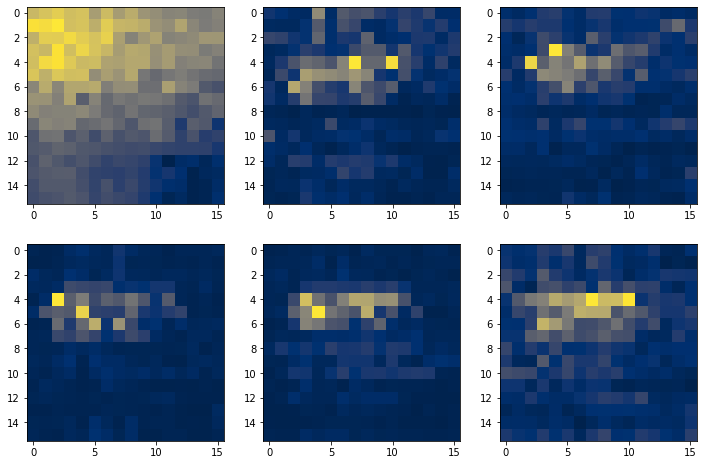

In [632]:
pix_h = 4
pix_w = 6
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs[0, 0].imshow(sattn11[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[0, 1].imshow(sattn12[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[0, 2].imshow(sattn13[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 0].imshow(sattn14[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 1].imshow(sattn15[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 2].imshow(sattn16[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
#plt.subplot_tool()
plt.show()

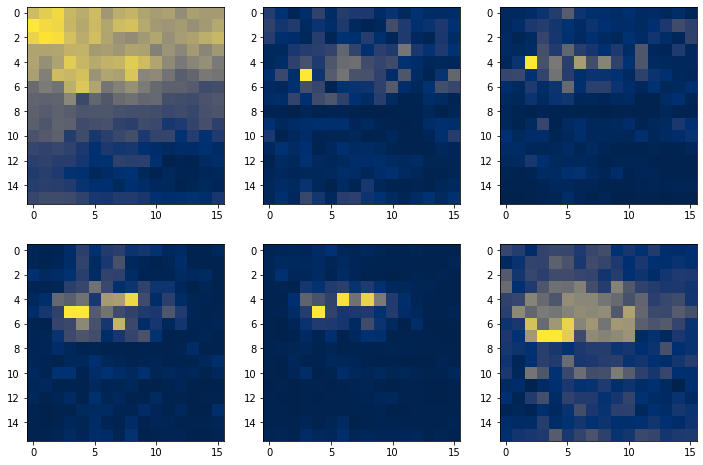

In [633]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs[0, 0].imshow(sattn21[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[0, 1].imshow(sattn22[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[0, 2].imshow(sattn23[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 0].imshow(sattn24[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 1].imshow(sattn25[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
axs[1, 2].imshow(sattn26[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')
#plt.subplot_tool()
plt.show()

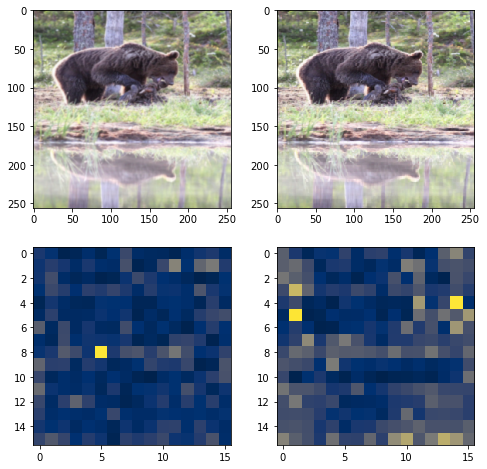

In [631]:
#threshold = torch.sum(sattn11[0,pix_h,pix_w,...])/1#/6.3665e-38
f, axs = plt.subplots(2,2,figsize=(8,8))
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
#plt.imshow(sattn11[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)
plt.imshow(img[0].cpu().permute(1, 2, 0),cmap='cividis', interpolation='nearest')
plt.subplot(223)
plt.imshow(sattn12[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)
plt.subplot(224)
plt.imshow(sattn22[0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)

In [29]:
def get_att_maps(model, k):
    start = timer()
    im = Image.open('sample_images/image'+str(k)+'.jpeg')
    img = transform(im).unsqueeze(0).to(device)

    outputs, attn, sattn, gm  = model(img.to(device))

    a = 16
    maps = [sattn[0].reshape(1,a,a,a,a),#.permute(0,3,4,1,2)
    sattn[1].reshape(1,a,a,a,a),#.permute(0,3,4,1,2)
    sattn[2].reshape(1,a,a,a,a),#.permute(0,3,4,1,2)
    sattn[3].reshape(1,a,a,a,a),#.permute(0,3,4,1,2)
    sattn[4].reshape(1,a,a,a,a),#.permute(0,3,4,1,2)
    sattn[5].reshape(1,a,a,a,a)]#.permute(0,3,4,1,2)

    return maps, im
    #print("Total time:", timer()-start) 

In [16]:
def show_attention_maps(im,i,j,maps_list):
    
    pix_h = i
    pix_w = j
    maps = [maps_list[0][0,pix_h,pix_w,...].cpu().detach().numpy(),
    maps_list[1][0,pix_h,pix_w,...].cpu().detach().numpy(),
    maps_list[2][0,pix_h,pix_w,...].cpu().detach().numpy(),
    maps_list[3][0,pix_h,pix_w,...].cpu().detach().numpy(),
    maps_list[4][0,pix_h,pix_w,...].cpu().detach().numpy(),
    maps_list[5][0,pix_h,pix_w,...].cpu().detach().numpy()]
    
    #start = timer()
    fig3 = plt.figure(constrained_layout=False, figsize=(16,7))
    fig3.set_constrained_layout_pads(w_pad=0.0, h_pad=0.0, hspace=0, wspace=0)
    gs = fig3.add_gridspec(2, 5)

    f3_ax1 = fig3.add_subplot(gs[:, :2])
    f3_ax1.set_title('Input Image', fontsize='xx-large')
    f3_ax1.imshow(im)
    f3_ax1.set_xticks([])
    f3_ax1.set_yticks([])
    f3_ax2 = fig3.add_subplot(gs[0, 2])
    f3_ax2.set_title('Layer 1', fontsize='x-large')
    f3_ax2.imshow(maps[0],cmap='cividis', interpolation='nearest')
    f3_ax2.set_xticks([])
    f3_ax2.set_yticks([])
    f3_ax3 = fig3.add_subplot(gs[0, 3])
    f3_ax3.set_title('Layer 2', fontsize='x-large')
    f3_ax3.imshow(maps[1],cmap='cividis', interpolation='nearest')
    f3_ax3.set_xticks([])
    f3_ax3.set_yticks([])
    f3_ax4 = fig3.add_subplot(gs[0, 4])
    f3_ax4.set_title('Layer 3', fontsize='x-large')
    f3_ax4.imshow(maps[2],cmap='cividis', interpolation='nearest')
    f3_ax4.set_xticks([])
    f3_ax4.set_yticks([])
    f3_ax5 = fig3.add_subplot(gs[1, 2])
    f3_ax5.set_title('Layer 4', fontsize='x-large')
    f3_ax5.imshow(maps[3],cmap='cividis', interpolation='nearest')
    f3_ax5.set_xticks([])
    f3_ax5.set_yticks([])
    f3_ax6 = fig3.add_subplot(gs[1, 3])
    f3_ax6.set_title('Layer 5', fontsize='x-large')
    f3_ax6.imshow(maps[4],cmap='cividis', interpolation='nearest')
    f3_ax6.set_xticks([])
    f3_ax6.set_yticks([])
    f3_ax7 = fig3.add_subplot(gs[1, 4])
    f3_ax7.set_title('Layer 6', fontsize='x-large')
    f3_ax7.imshow(maps[5],cmap='cividis', interpolation='nearest')
    f3_ax7.set_xticks([])
    f3_ax7.set_yticks([])

    fig3.subplots_adjust(hspace=0.0)
    title = 'Attention maps for position ('+str(i)+','+str(j)+')'
    fig3.suptitle(title, fontsize=28)
    #if best_model == True:
    #    file_title = 'sample_images/attention_maps/raw/'+model_name+'/image_'+str(k)+'_position_'+str(i)+'x'+str(j)+'_BEST.jpeg'
    #else:
    #    file_title = 'sample_images/attention_maps/raw/'+model_name+'/image_'+str(k)+'_position_'+str(i)+'x'+str(j)+'.jpeg'
    #fig3.savefig(file_title,dpi=100, bbox_inches='tight', pad_inches=0.0)
    #print('Image '+str(k)+' Attention maps for position ('+str(i)+','+str(j)+') saved in ', timer()-start)

In [21]:
def paths(layer = 1, base_model=False, best_model=False, pf="3"): 
    model_dir = Path.home()/'Luiz/saved_models'
    if base_model == True:
        model_path = model_dir/'GramImageNet_Rotation_16x16grid_epochs-90_BaseModel.pkl'
    else:
        file_name = 'GramImageNet_Rotation_16x16grid_epochs-90-beta-5e-6_PenaltyFactor'+pf+'_Layer'+str(layer)+'.pkl'
        model_path = model_dir/file_name
        
    if best_model == True:
        weight_dir = Path.home()/'Luiz/gan_attention/models/pretrained/'
        if base_model == True:
            file_name = 'Best_Model_BaseModel_ImageNet_Rotation_16x16grid.pth'
        elif pf !="3":
            file_name = 'Best_Model_Layer'+str(layer)+'_ImageNet_Rotation_16x16grid_Loss'+pf+'.pth'
        else:
            file_name = 'Best_Model_Layer'+str(layer)+'_ImageNet_Rotation_16x16grid.pth'
        weights_path = weight_dir/file_name
    else:
        weights_path = None
        
    return model_path, weights_path

In [22]:
def load_model(model_path, weights_path = None):
    model_dir = Path.home()/'Luiz/saved_models'
    net = load_learner(model_path, cpu=False)
    model = net.model.eval()

    if weights_path != None:
        weight_dict = load_learner(weights_path, cpu=False)
        model.load_state_dict(weight_dict)
    
    model.to(device)
        
    return model

In [23]:
def run_load_model(layer,base_model,best_model,pf):
    model_path, weight_path = paths(layer, base_model, best_model, pf)
    #print(model_path)
    #print(weight_path)
    model = load_model(model_path,weight_path)
    return model

In [25]:
model = run_load_model(3,False,False,"3")

In [30]:
maps, im = get_att_maps(model, 16)

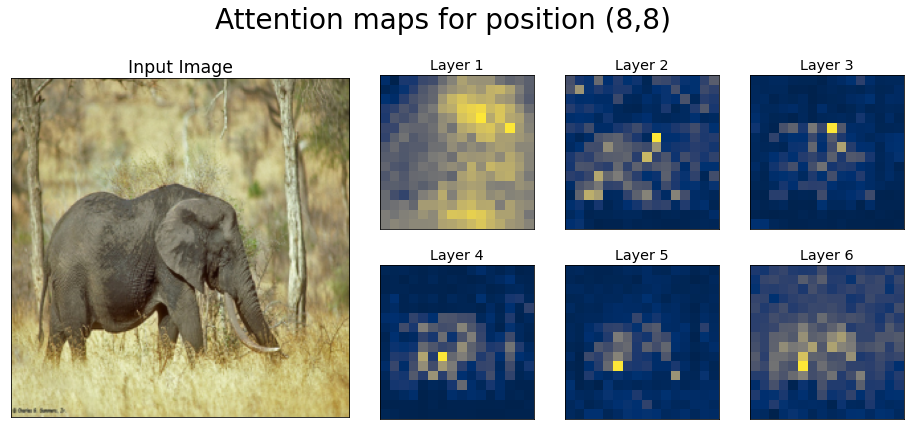

In [31]:
show_attention_maps(im,8,8,maps)

In [ ]:
Lattn = Curating_of_attention_mask(patch_size=32, width=256, height=256, map_width=256, map_height=256, grid_l=1,)

In [ ]:
pattn = Lattn(img[0].cpu().detach())
pattn.shape

In [ ]:
m = nn.AvgPool2d(2, stride=2)

In [ ]:
a = m(sattn[5].reshape(1,256,16,16)).clone()
print(a.shape)
b = m(a.reshape(1,256,64).permute(0, 2, 1).reshape(1,64,16,16)).permute(0, 2, 3, 1).reshape(1,64,64).clone()
c = b
for i in range(1):
    high = c[i].max().item()
    low = c[i].min().item()
    print("Max:", high)
    print("Min:", low)
    c[i] = c[i] - low
    print("====================")
    print("Max:", c[i].max().item())
    print("Min:", c[i].min().item())
    c[i] = c[i] / (high-low)
    print("====================")
    print("Max:", c[i].max().item())
    print("Min:", c[i].min().item())

c = c+0.0001

In [ ]:
sattn2[0].shape

In [ ]:

c = c - c[0].min().item()

In [ ]:
print(sattn[0].shape)
plt.subplot(221)
plt.imshow(sattn[5][0].cpu().detach().numpy())
plt.subplot(222)
plt.imshow(pattn[0].cpu().detach().numpy())
plt.subplot(223)
plt.imshow(b[0].cpu().detach().numpy())
plt.subplot(224)
plt.imshow(c[0].cpu().detach().numpy())

In [ ]:
a[0].max().item()

In [ ]:
print("MAX")
print(sattn2[0][0].max())
print(a[0].max())
print(b[0].max())
print(c[0].max())

print("MIN")
print(sattn2[0][0].min())
print(a[0].min())
print(b[0].min())
print(c[0].min())

In [ ]:
(pattn[0]-0.001)[7]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [99]:
class AttentionVisualizer:
    def __init__(self, model, transform, attn_layer,img_url = None,img_idx = None):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None
        self.attn_layer = attn_layer
        self.img_url = img_url
        self.img_idx = img_idx

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value=self.img_url,
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        outputs, dec_attn_weights, enc_attn_weights, gm = model(img.to(device))
        #conv_features, enc_attn_weights, dec_attn_weights = model(img.to(device))

        #hooks = [
        #    model.backbone[-2].register_forward_hook(
        #        lambda self, input, output: conv_features.append(output)
        #    ),
        #    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #        lambda self, input, output: enc_attn_weights.append(output[1])
        #    ),
        #    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        #        lambda self, input, output: dec_attn_weights.append(output[1])
        #    ),
        #]
        # propagate through the model
        #outputs = model(img)

        #for hook in hooks:
        #    hook.remove()

        # don't need the list anymore
        self.conv_features = outputs
        self.dec_attn_weights = dec_attn_weights
        # get the HxW shape of the feature maps of the CNN
        #print(enc_attn_weights.shape)
        shape = enc_attn_weights[self.attn_layer].shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[self.attn_layer][0].reshape(16,16,16,16)
        #print(self.enc_attn_weights.shape)
    
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            if self.img_idx != None:
                print("Loading from file")
                path = '/home/atsumilab/Luiz/gan_attention/'
                self.pil_img = Image.open(path+'sample_images/image'+str(self.img_idx)+'.jpeg')
            else:
                print("Loading from the web")
                self.pil_img = transform2(Image.open(requests.get(url, stream=True).raw))
            #else:
            #    print("Loading from the web")
            #    self.pil_img = transform2(Image.open(requests.get(url, stream=True).raw))
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)
    
    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)
            
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
                threshold = torch.sum(sattn_map)/100
            else:
                sattn_map = sattn[idx[0], idx[1],...]
                threshold = torch.sum(sattn_map)/100
            axs[1].imshow(sattn_map.cpu().detach().numpy(), cmap='cividis', interpolation='nearest',vmax=threshold)
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()
        
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [100]:
w = AttentionVisualizer(model, transform, 2, url1, 4)
w.run()

In [96]:
Path.home()/'Luiz/gan_attention/'

Path('/home/atsumilab/Luiz/gan_attention')